In [1]:
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [2]:
file_dir = os.getcwd()
data_dir = os.path.join(file_dir, 'datasets')

In [3]:
cds_csv_path = os.path.join(data_dir, 'cds.csv')
cds_data = pd.read_csv(cds_csv_path, index_col='Date')

In [4]:
cds_data.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


In [24]:
def autocorrelation_plotter(dataset, ticker, lagmin=1, lagmax=50):

    tickerset = dataset[dataset['Ticker'] == ticker]
    px_columns = [f'PX{i}' for i in range(1, 11)]

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
    axes = axes.flatten()

    # iterate over PX columns and plot ACF for each
    for i, col in enumerate(px_columns):
        price_col = tickerset[col]

        plot_acf(price_col, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
        axes[i].set_xlim(lagmin, lagmax)
        axes[i].set_xlabel("Lags")
        axes[i].set_ylabel("Autocorrelation")
    
    plt.tight_layout()
    plt.suptitle(f"Autocorrelation of CDS Prices for Ticker: {ticker}", fontsize=14, y=1.02)
    plt.show()

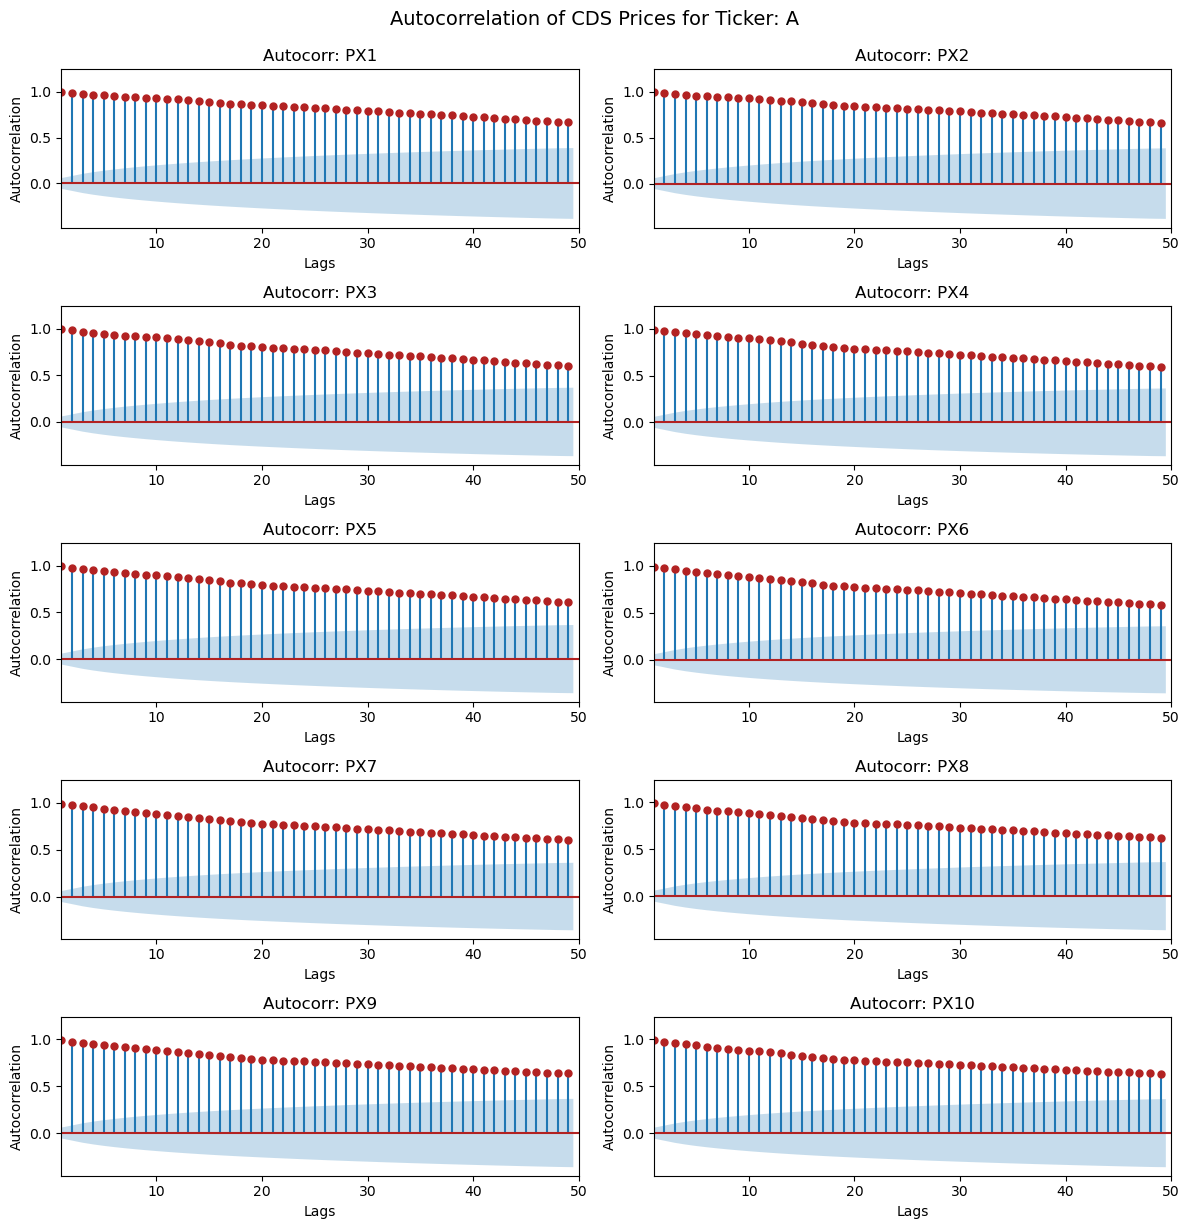

In [25]:
autocorrelation_plotter(cds_data, 'A')